### Quantifying and Visualizing Distribution Shift in Augmented Test Sets
Now that we have generated perturbed variants of the test set, we would like to investigate how the noise affects the distribution of the data. 

#### 1. Quantifying Distribution Shift
- Extract relevant features from both the original and noisy datasets. These features might include word frequencies, sentence lengths, POS tag distributions, etc., depending on what aspects of the data the noise might affect.

#### 2. Visualizing Distribution Shift
a) Histograms:
- Plot histograms for features like sentence length, word frequency, etc., for both datasets. Overlaying these histograms can provide a visual comparison.

b) Box Plots:
- Box plots are useful for visualizing the distribution of numerical features (e.g., sentence length).

c) Word Clouds:
- Generate word clouds for the original and noisy datasets to visually compare the most frequent words.

d) POS Tag Distribution:
- If you have POS tag features, visualize their distribution in both datasets using bar plots.

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import re
from tqdm import tqdm
from typing import Dict

### Load data and generate features

In [17]:
def load_datasets(input_dir):
    datasets = {}
    for file in os.listdir(input_dir):
        if file.endswith(".csv"):
            noise_levels = re.findall(r'_(psr|ppr|pri|prs|prd)(\d{3})', file)
            noise_dict = {typ: int(level) / 100 for typ, level in noise_levels}

            df = pd.read_csv(os.path.join(input_dir, file), sep='\t')
            datasets[file] = {'data': df, 'noises': noise_dict}

    return datasets

datasets = load_datasets('/Users/johann/Documents/Uni/real-time-uncertainty-text-classification/data/robustness-study/preprocessed_noisy')


In [18]:
# features
def calculate_word_frequencies(df):
    word_freq = {}
    for text in df['text']:
        words = text.split()
        for word in words:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq

def calculate_sentence_lengths(df):
    sentence_lengths = df['text'].apply(lambda x: len(x.split()))
    return sentence_lengths

def calculate_pos_distributions(df):
    pos_counts = Counter()
    for text in df['text']:
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        pos_counts.update([tag for _, tag in tags])
    return pos_counts


In [23]:
# compute features for each dataset
# use tqdm to show progress bar

for filename, content in tqdm(datasets.items(), desc='Calculating features'):
    df = content['data']

    word_frequencies = calculate_word_frequencies(df)
    sentence_lengths = calculate_sentence_lengths(df)
    pos_distributions = calculate_pos_distributions(df)

    datasets[filename]['word_freq'] = word_frequencies
    datasets[filename]['sentence_lengths'] = sentence_lengths
    datasets[filename]['pos_distributions'] = pos_distributions


Calculating features: 100%|██████████| 51/51 [01:30<00:00,  1.76s/it]


### Visualize distribution shift

In [37]:
def get_average_sentence_lengths(datasets: Dict, noise_type=None):
    """
    Get average sentence lengths for all datasets / noise types or for a specific noise type.
    :param datasets: 
    :param noise_type: 
    :return: avg_sentence_lengths
    """
    avg_sentence_lengths = {}

    if noise_type is None:
        # get average sentence length for all datasets / noise types
        for filename, data in datasets.items():
            for noise_type, noise_level in data['noises'].items():
                if noise_type not in avg_sentence_lengths:
                    avg_sentence_lengths[noise_type] = {}
                avg_sentence_lengths[noise_type][noise_level] = data['sentence_lengths'].mean()
            noise_type = list(data['noises'].keys())[0]
            noise_level = data['noises'][noise_type]
            avg_sentence_length = data['sentence_lengths'].mean()
            avg_sentence_lengths[noise_type][noise_level] = avg_sentence_length

    else:
        # get average sentence length for a specific noise type
        for filename, data in datasets.items():
            if noise_type in data['noises']:
                noise_level = data['noises'][noise_type]
                avg_sentence_length = data['sentence_lengths'].mean()
                avg_sentence_lengths[noise_level] = avg_sentence_length
    
    return avg_sentence_lengths

In [38]:
avg_sentence_lengths = get_average_sentence_lengths(datasets)

In [41]:
def plot_sentence_length_distribution(avg_sentence_lengths):
    """
    Plot sentence length distribution for all datasets / noise types or for a specific noise type.
    :param avg_sentence_lengths: 
    :return: 
    """
    for noise_type, noise_levels in avg_sentence_lengths.items():
        plt.figure()
        plt.title(f'Sentence Length Distribution for {noise_type}')
        plt.xlabel('Noise Level')
        plt.ylabel('Average Sentence Length')
        plt.scatter(list(noise_levels.keys()), list(noise_levels.values()))
        plt.show()

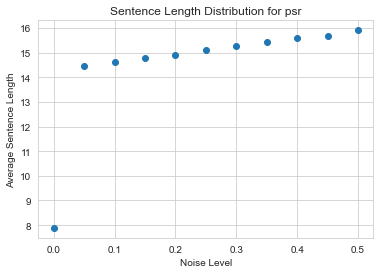

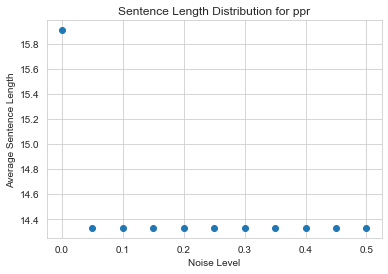

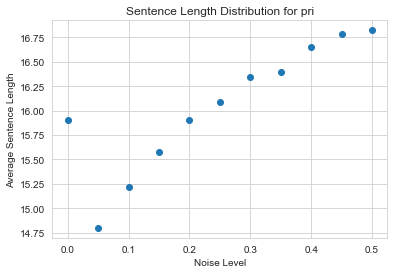

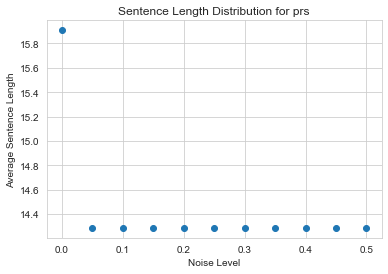

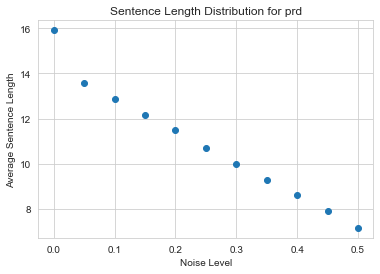

In [42]:
plot_sentence_length_distribution(avg_sentence_lengths)